# Exploring Bulk Variables from the Spotter Archive

See [Spotter Technical Manual](https://content.sofarocean.com/hubfs/Spotter%20product%20documentation%20page/Sofar%20-%20Technical_Reference_Manual.pdf) for details on bulk wave parameters from directional wave buoys like Spotter.


This notebook demonstrates plotting the locations and wave height observations of Spotters at the beginning and end of the archive as well as a focus on Spot-0164, as described in the [Sofar blog](https://www.sofarocean.com/posts/chronicling-ocean-buoy-20000-mile-journey).

Here, we remotely access zarr files stored on S3. All data access methods remain the same if using the netCDF file downloaded locally, e.g., `ds = xr.load_dataset(local_filename)`. The xarray + zarr allows for efficient remote access of the data without full download, but does require internet connection.

In [1]:
# Import necessary packages (you may need to pip install in your environment)

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # for mapping
import xarray as xr
import datetime

import numpy as np

import s3fs
import matplotlib.dates as mdates

## Option A: Load netcdf dataset with xarray + zarr

In [2]:
# open the file using xarray and zarr

s3_uri = "s3://sofar-spotter-archive/spotter_data/"

s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root=s3_uri, s3=s3, check=False)
ds = xr.open_zarr(store=store, consolidated=True)
ds

<xarray.Dataset>
Dimensions:                (index: 7017462, trajectory: 897)
Coordinates:
    time                   (index) datetime64[ns] ...
  * trajectory             (trajectory) object 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    latitude               (index) float64 ...
    longitude              (index) float64 ...
    meanDirection          (index) float64 ...
    meanDirectionalSpread  (index) float64 ...
    meanPeriod             (index) float64 ...
    peakDirection          (index) float64 ...
    peakDirectionalSpread  (index) float64 ...
    peakPeriod             (index) float64 ...
    rowsize                (trajectory) int64 ...
    significantWaveHeight  (index) float64 ...
Attributes:
    author:         Isabel A. Houghton
    creation_date:  2023-09-19 22:47:00.976740
    email:          isabel.houghton@sofarocean.com
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...

## Option B: Load from local netCDF file
- comment out zarr access above / uncomment block below
- update local_filepath to correspond to where .nc file is downloaded on your local machine

In [3]:
# local_filename = "~/Downloads/spotter_data_spectra.nc"
# ds = xr.load_dataset(local_filename)
# ds

## All H$_s$ observations at the beginning and end of the archive

In [4]:
# set plotting parameters (min, max for colors and map projection)
h_min = 1
h_max = 6

proj = ccrs.PlateCarree(central_longitude=180)

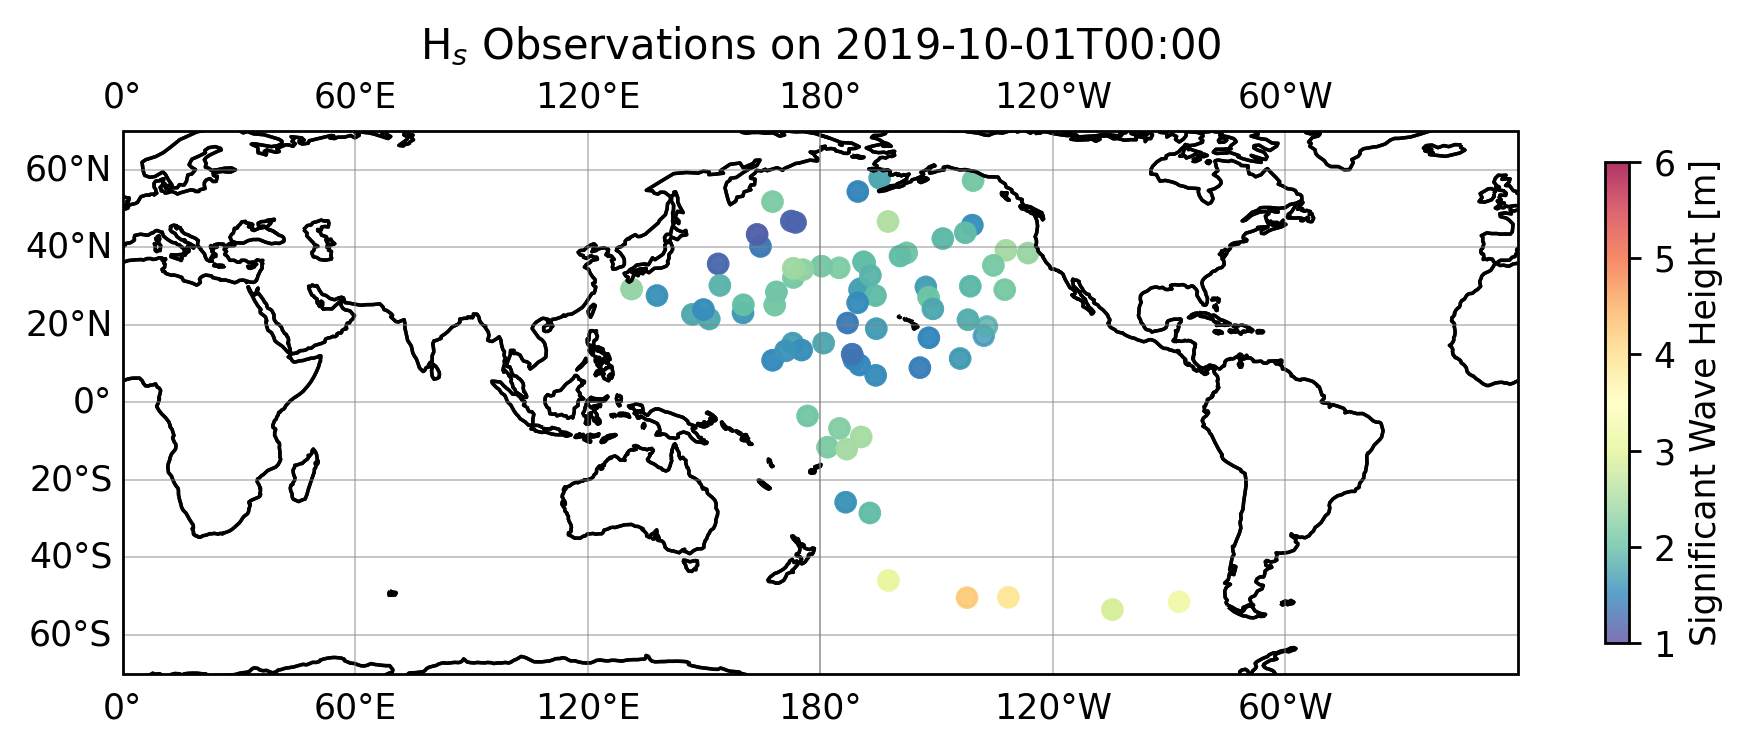

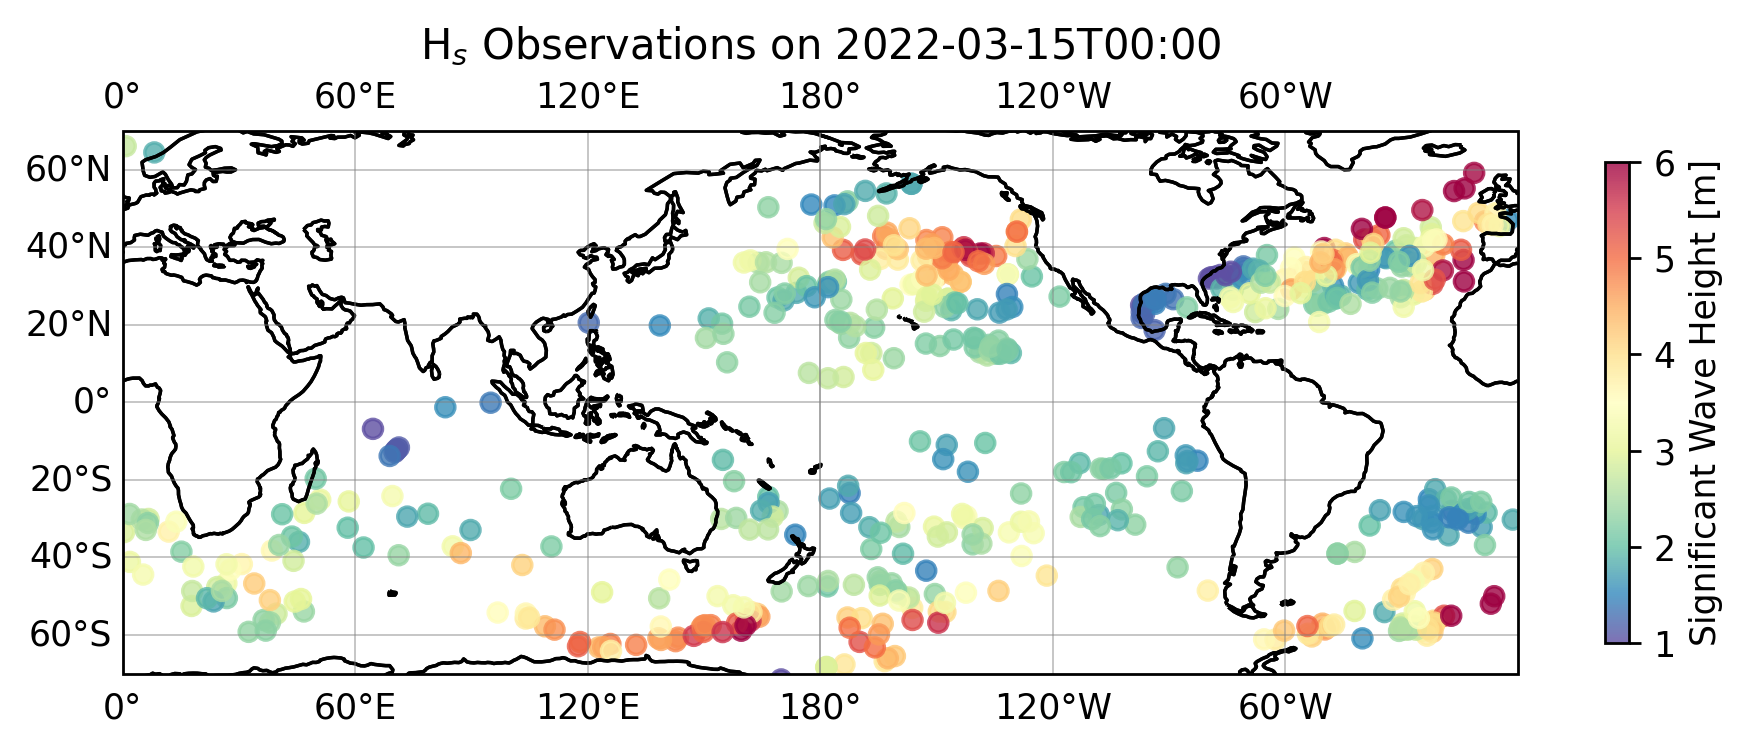

In [5]:
# loop over dates of interest
for time_string in ['2019-10-01T00:00', '2022-03-15T00:00']:
    target_time_start = np.datetime64(time_string)
    target_time_end = np.datetime64(time_string) + np.timedelta64(1,'h')
    
    # find all data points at time of interest
    all_indices = np.where((ds.time>target_time_start) & (ds.time<target_time_end))[0]

    # set up cartopy map
    fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=.5, color='gray', alpha=0.5)

    ax.set_extent([0, 360, -70, 70], crs=ccrs.PlateCarree())
    ax.coastlines()


    pcm1 = ax.scatter(ds.longitude[all_indices], 
                      ds.latitude[all_indices],
                      c=ds.significantWaveHeight[all_indices],
                      s=30,
                      cmap='Spectral_r',
                      alpha=0.8,
                      vmin=h_min, vmax=h_max,
                     transform=ccrs.PlateCarree())

    cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5)

    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(f'H$_s$ Observations on {target_time_start}')
    plt.show()

## Plot drift trajectory for individual drifter colored by date

In [6]:
# choose a drifter by ID
spotter_id = 'SPOT-0164'


# create array that points to indices for each trajectory
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)


# find index of chosen drifter
j = np.where(ds.trajectory==spotter_id)[0][0]
print(f"Drifter index for {spotter_id} is {j}")


# create the slice index `sli` for data from that drifter
sli = slice(traj_idx[j], traj_idx[j+1])

Drifter index for SPOT-0164 is 257


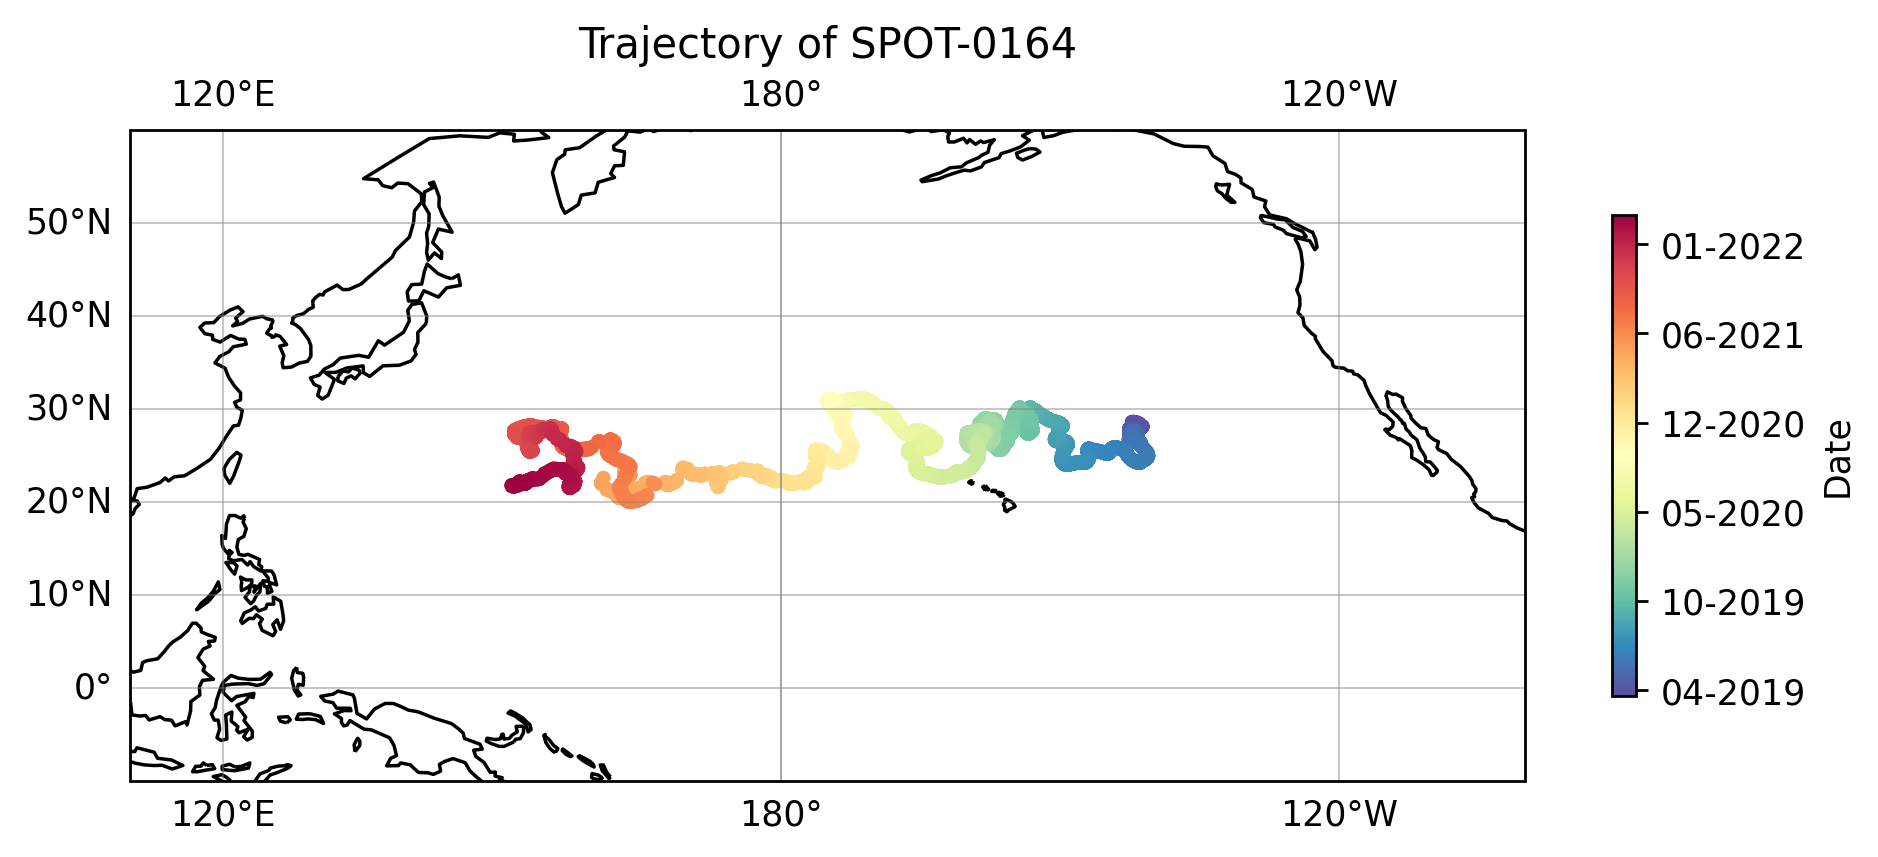

In [7]:
# set up cartopy map
fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5)

ax.set_extent([110, 260, -10, 60], crs=ccrs.PlateCarree())


lons = ds.longitude[sli]
lons[lons<0] += 360 # make sure lons span [0,360] for easier mapping
lats = ds.latitude[sli]
pcm1 = ax.scatter(lons, lats,
                  c=mdates.date2num(ds.time[sli]),
                  s=10,
                  cmap='Spectral_r',
                  edgecolor='face',
                  transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Date', shrink=0.5)
cb.ax.yaxis.set
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Trajectory of '+str(spotter_id))
plt.show()

## Plot drift trajectory colored by H$_s$

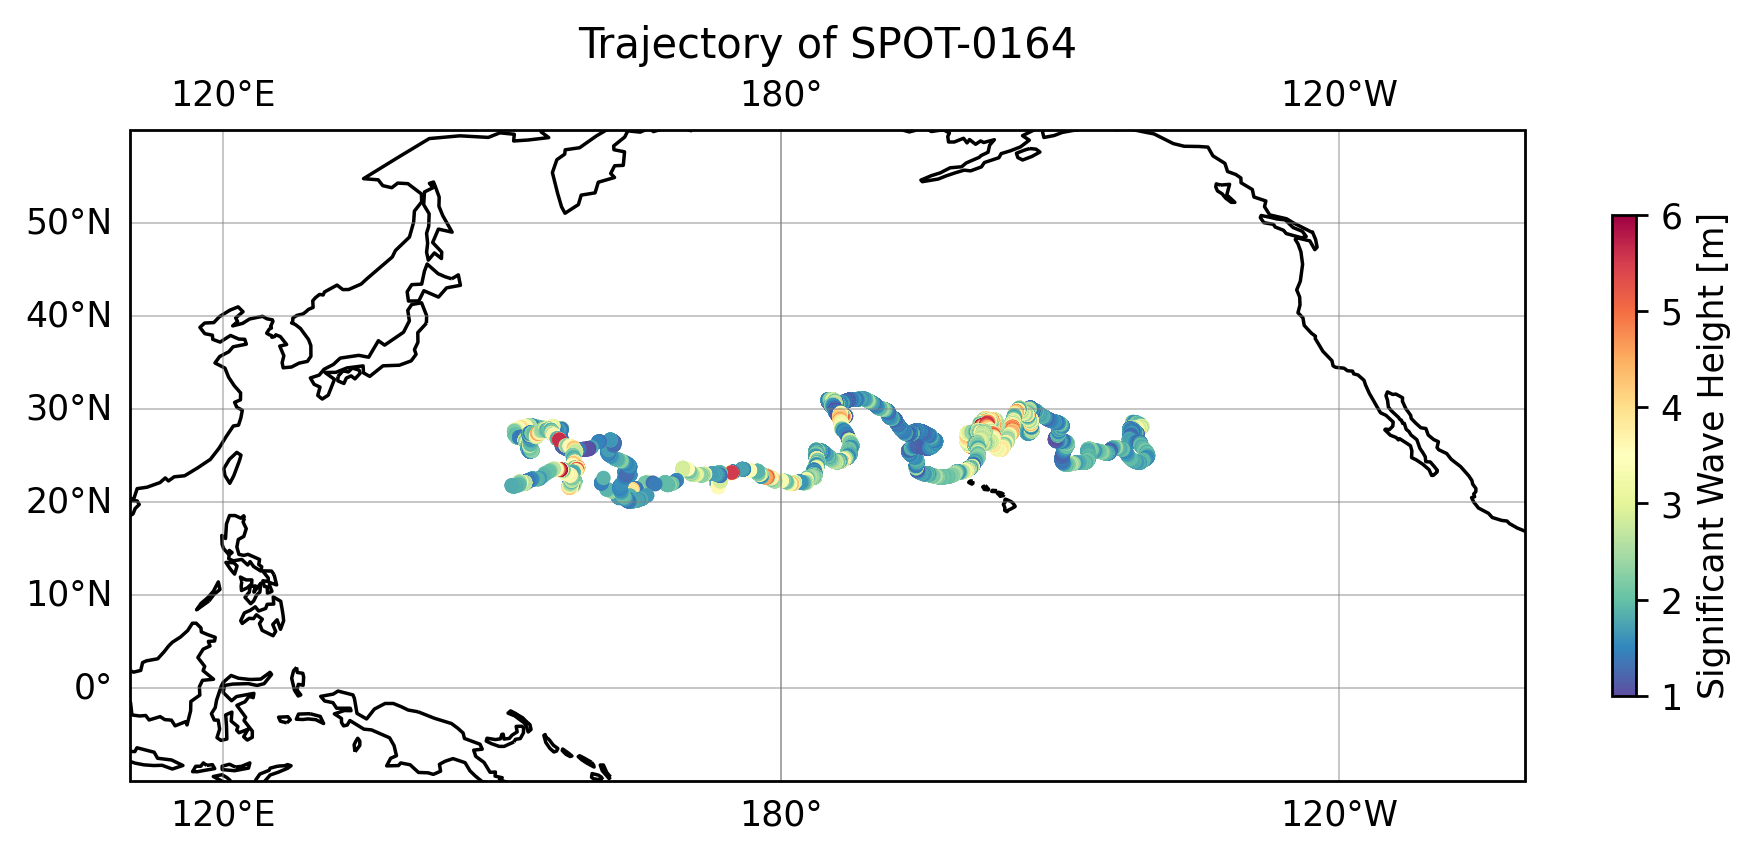

In [8]:
fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5)

ax.set_extent([110, 260, -10, 60], crs=ccrs.PlateCarree())

pcm1 = ax.scatter(lons, lats,
                  c=ds.significantWaveHeight[sli],
                  s=10,
                  cmap='Spectral_r',
                  edgecolor='face',
                  vmin=h_min, vmax=h_max,
                  transform=ccrs.PlateCarree())

cb = fig.colorbar(pcm1,ax=ax, label='Significant Wave Height [m]', shrink=0.5)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Trajectory of '+str(spotter_id))
plt.show()

## Plot H$_s$ time series

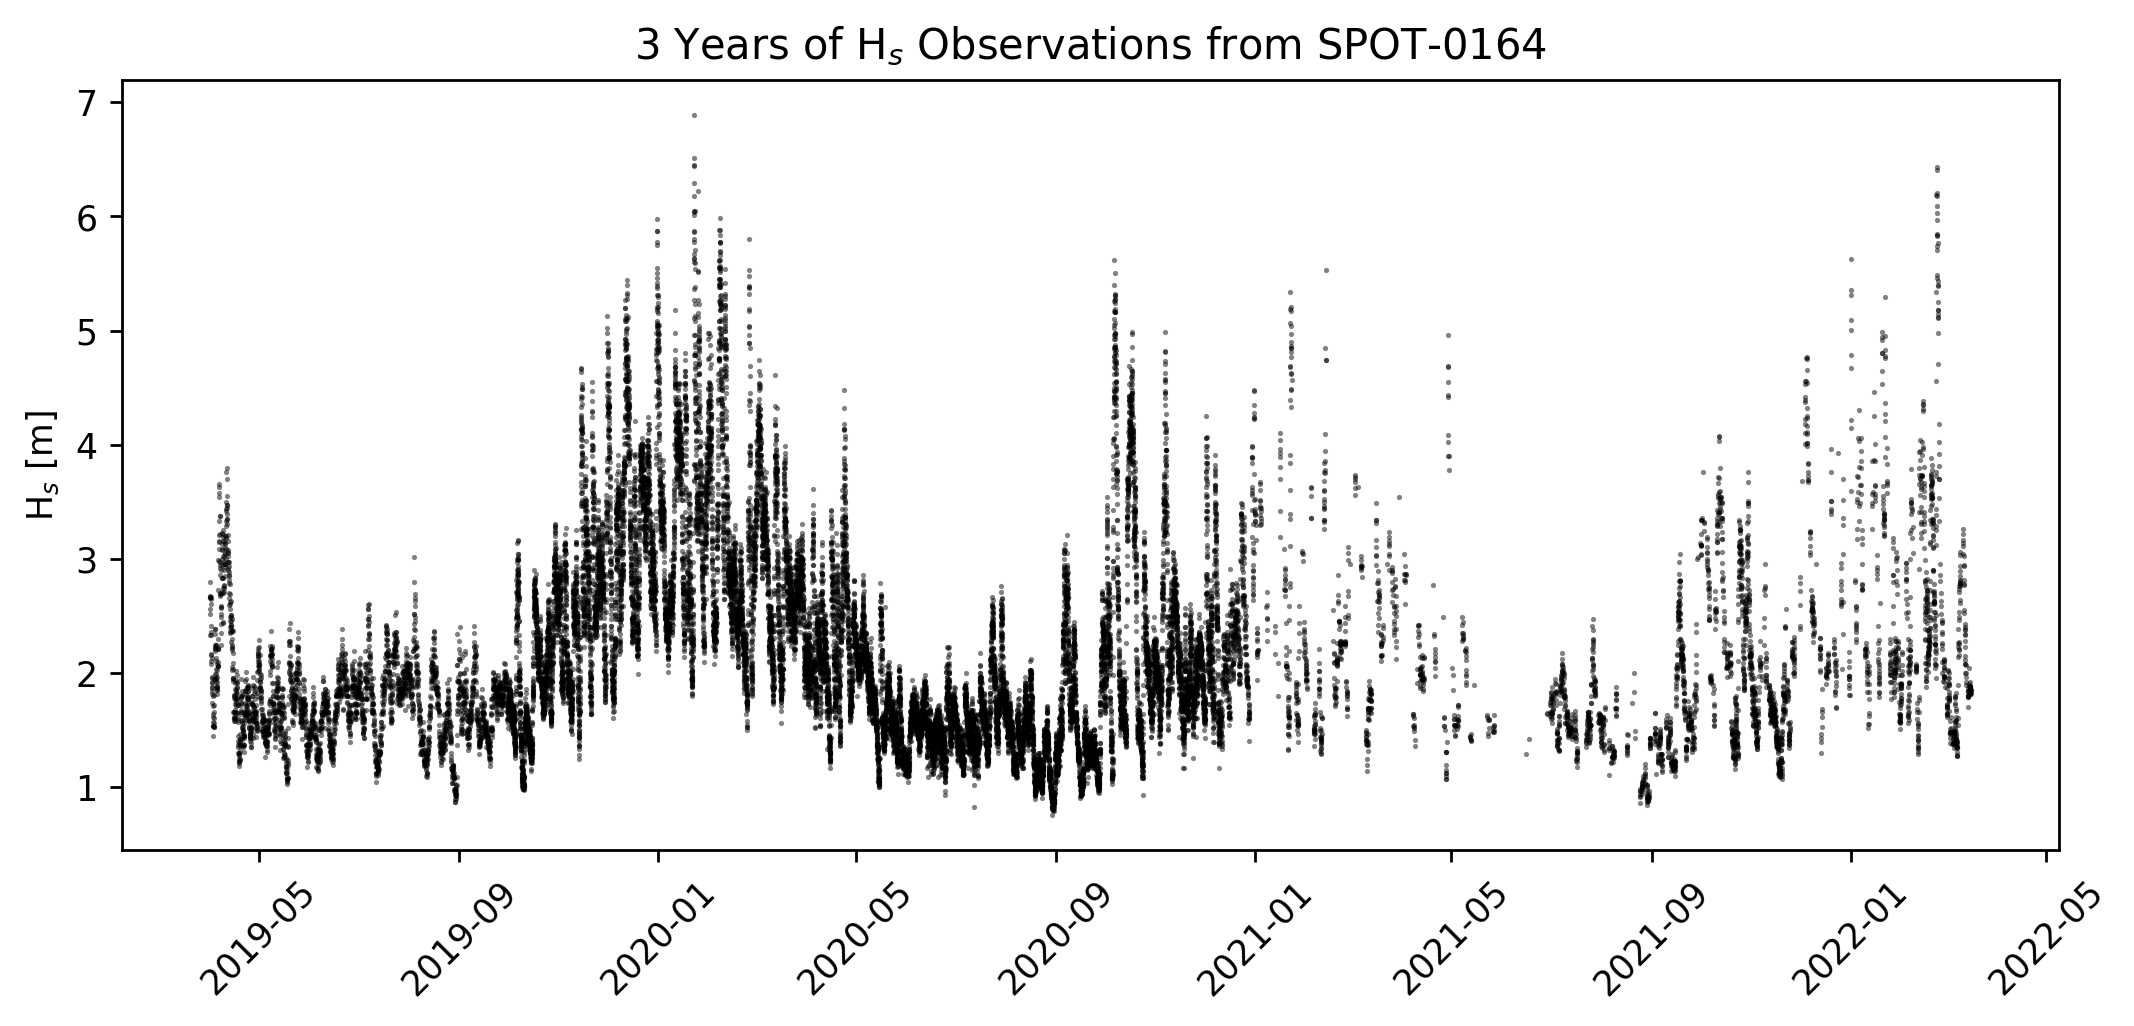

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=250)
ax.scatter(ds.time[sli], ds.significantWaveHeight[sli], c='k',alpha=0.5, marker='.', s=1)

plt.xticks(rotation=45)
plt.ylabel('H$_s$ [m]')
plt.title(f"3 Years of H$_s$ Observations from {spotter_id}")
plt.show()